# Data Preparation

## Load data from sqlite3 in json

In [1]:
from utils.db.get_data_db import get_data_json
## accuracy
from utils.information_retrieval import get_times_per_tt, get_confidence_per_tt, get_answers_scores_multiple_sel, get_answers_scores_single_sel
from utils.models import get_inference_sinlg
##
from utils.information_retrieval import get_data_response_pair_plot, get_data_forest_plot, get_num_of_boxes_per_task, get_len_of_boxes_per_task, get_num_of_boxes_per_participant_per_task
from utils.models import get_times_inference, get_answers_rq1_inference, get_confidence_inference, get_num_boxes_inference, get_len_boxes_inference
from utils.visualization import combined_forest_plot, pair_plot_of_means
from utils.information_retrieval import  get_means_from_traces, get_data_interaction_scatter_plot, get_data_response_interaction_pair_plot, get_data_ordered_forest_plot
from utils.visualization import scatter_plot_of_num_len_boxes,pair_plot_response_interaction, combined_oredered_forest_plot
# conda install -c conda-forge adjusttext

import numpy as np

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_02.db'
data = get_data_json(db_file_path)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data cleaning

Remove any incomplete registration created when participants by mistake clicked multiple times the "Registration" button.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end" or data[p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Research Question (RQ) and group (IG and SG)

<!-- There are 3 research questions in the study. -->

RQ1: Does interaction help users to identify the existence or not of (strong) relations among probabilistic models’ parameters 

RQ2: Does interaction help users to identify the type of relation of model’s parameters and/or predictions 

RQ3: Does interaction help users to infer structural information about the model

more accurately, faster and with more confidence?

IG: Interactive Group

SG: Static Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per RQ
t_ids = {}
t_ids['T1'] = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
t_ids['T2'] = ['t11','t12','t13','t14','t15','t16']

## times
times_i, times_s, times_a = get_times_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## confidence
conf_i, conf_s, conf_a = get_confidence_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## corr answ taken responses as multiple choice selections
answ_sc_i_multi, answ_sc_s_multi, answ_sc_a_multi = get_answers_scores_multiple_sel(data_processed, 
                                                                                                 t_ids['T1'], 
                                                                                                 db_file_path) # returns Dict<t_id:List>
## corr answ taken responses as multiple choice selections
answ_sc_i_singl, answ_sc_s_singl, answ_sc_a_singl = get_answers_scores_single_sel(data_processed, 
                                                                                               t_ids['T1'], 
                                                                                               db_file_path) # returns Dict<t_id:List>

In [4]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
#indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_singl.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_singl.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_singl.items() 
               for j in value]

trace_acc_T1_singl, pp_acc_T1_singl = get_inference_sinlg(ans_i, 
                                                        ans_s,
                                                        ans_a,
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_indices_a, 
                                                        t_ids['T1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


Text(0.5, 0, 'SG-AG')

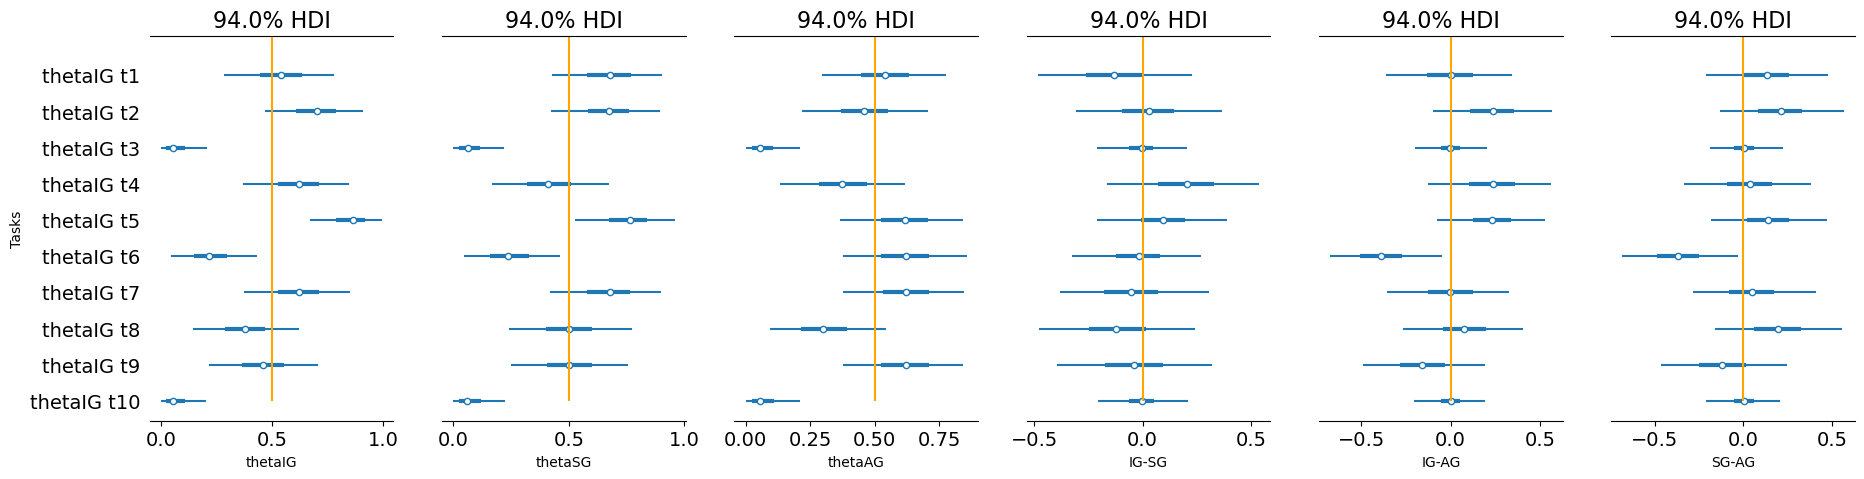

In [38]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_singl)
# ai['posterior']
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True)
ax[3].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True)
ax[4].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True)
ax[5].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("IG-SG")
ax[4].set_xlabel("IG-AG")
ax[5].set_xlabel("SG-AG")

In [ ]:
# number of trials (available options) per task in TT1
n_sizes_per_task = {'t1':2,'t2':2,'t3':2,'t4':2, }
n_i = [n_sizes_per_task[t] 
       for t,value in corr_answers_i['rq1'].items() 
       for j in value]
n_s = [n_sizes_per_task[t] 
       for t,value in corr_answers_s['rq1'].items() 
       for j in value]
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq1'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq1'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_s['rq1'].items() 
               for j in value]
trace_acc_rq1, pp_acc_rq1 = get_answers_rq1_inference(ans_i, 
                                                      ans_s, n_i, n_s, 
                                                      t_indices_i, 
                                                      t_indices_s, 
                                                      t_ids['rq1'])

## Get observed Numbers and Lengths of Interactive Selection Boxes per Task

In [4]:
t_ids_all = [f"t{i+1}" for i in range(19)]
num_of_boxes = get_num_of_boxes_per_task(data_processed, t_ids_all) 

p_tasks = {"p1":['t1','t2',"t3","t4",'t5'],"p2":['t6','t7',"t8","t9",'t10','t11'],"p3":['t12','t13',"t14","t15",'t16','t17','t18','t19']}
p_vars = {"p1":['a','b','c','temperature'],"p2":['a','b','c','random_number'],"p3":['a','b','c','d','reaction_time']}
p_inference = {"p1":np.load('data/min_temperature.npz') ,"p2":np.load('data/transformation.npz'),"p3":np.load('data/reaction_times_hierarchical.npz')}
len_of_boxes = get_len_of_boxes_per_task(data_processed, p_tasks, p_vars, p_inference)

## Get number of boxes per participant and task in IG

In [5]:
num_boxes_perPartTask = get_num_of_boxes_per_participant_per_task(data_processed, t_ids_all)
## print p_id and t_id with 0 boxes
for p,t_dict in num_boxes_perPartTask.items():
    for t in t_dict:
        if t_dict[t] == 0:
            print(p,t)

9 t19
111 t3
111 t4
111 t5
111 t6
111 t15
112 t5
171 t5


## t18 responses

In [6]:
def answers_per_task(participants, t_ids, data):
    """
        participants: List of participants id to consinder
        t_ids:        List of Strings of task ids
        data:         Dict with processed data from database
    """
    answers_per_task = {}
    for p in participants:
        for t in t_ids:
            if t in data[p]['t_answers']:
                if t not in answers_per_task:
                    answers_per_task[t] = []
                answers_per_task[t].append(data[p]['t_answers'][t]['answer'])
    return answers_per_task
an_t18_i = answers_per_task([p for p,p_details in data_processed.items() if p_details['mode'] == 'i'],t_ids_all,data_processed)["t18"]
an_t18_s = answers_per_task([p for p,p_details in data_processed.items() if p_details['mode'] == 's'],t_ids_all,data_processed)["t18"]

In [7]:
an_t18_i

[['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(C) “a” sets the average value of reaction times and “c” doesn’t affect reaction times'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(C) “a” sets the average value of reaction times and “c” doesn’t af

In [8]:
an_t18_s

[['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(D) “c” sets the average value of reaction times and “a” doesn’t affect reaction times'],
 ['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(C) “a” sets the average value of reaction times and “c” doesn’t affect reaction times'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['There is no effect'],
 ['(C) “a” sets the average value of reaction times and “c” doesn’t affect reaction times'],
 ['(A) “a” sets the average value of reaction times and “c” sets the average value of “a”'],
 ['(B) “c” sets the average value of reaction times and “a” sets the average value of “c”'],
 ['(C) “a” sets the average value of reaction

# Bayesian Analysis of Collected Data

## Inference for RQ1

### Response Times

In [9]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq1'].items() for j in value]
tim_s = [j for _,value in  times_s['rq1'].items() for j in value]
#indices
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in times_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in times_s['rq1'].items() 
               for j in value]
trace_rt_rq1, pp_rt_rq1 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


### Accuracy
We model the probability of making a mistake in identifying the existence or not of a relation.

In [10]:
# number of trials (available options) per task in rq1
n_sizes_per_task = {'t1':3,'t6':3,'t12':4,'t13':3}
n_i = [n_sizes_per_task[t] 
       for t,value in corr_answers_i['rq1'].items() 
       for j in value]
n_s = [n_sizes_per_task[t] 
       for t,value in corr_answers_s['rq1'].items() 
       for j in value]
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq1'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq1'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in corr_answers_s['rq1'].items() 
               for j in value]
trace_acc_rq1, pp_acc_rq1 = get_answers_rq1_inference(ans_i, 
                                                      ans_s, n_i, n_s, 
                                                      t_indices_i, 
                                                      t_indices_s, 
                                                      t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


### Confidence

In [11]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq1'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq1'].items() 
       for j in value]
#indices
t_indices_i = [t_ids['rq1'].index(t) 
               for t,value in conf_i['rq1'].items() 
               for j in value]
t_indices_s = [t_ids['rq1'].index(t) 
               for t,value in conf_s['rq1'].items() 
               for j in value]

trace_conf_rq1, pp_conf_rq1 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq1'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


## Inference for RQ2

### Response Times

In [12]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq2'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq2'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in times_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in times_s['rq2'].items() 
               for j in value]
trace_rt_rq2, pp_rt_rq2 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


### Accuracy

In [13]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq2'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq2'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in corr_answers_s['rq2'].items() 
               for j in value]

trace_acc_rq2, pp_acc_rq2 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


### Confidence

In [14]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq2'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq2'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq2'].index(t) 
               for t,value in conf_i['rq2'].items() 
               for j in value]
t_indices_s = [t_ids['rq2'].index(t) 
               for t,value in conf_s['rq2'].items() 
               for j in value]
trace_conf_rq2, pp_conf_rq2 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq2'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


## Inference for RQ3

### Response Times

In [15]:
# interactive and static response times
tim_i = [j for _,value in times_i['rq3'].items() 
         for j in value]
tim_s = [j for _,value in  times_s['rq3'].items() 
         for j in value]
#indices
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in times_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in times_s['rq3'].items() 
               for j in value]
trace_rt_rq3, pp_rt_rq3 = get_times_inference(tim_i, 
                                              tim_s, 
                                              t_indices_i, 
                                              t_indices_s, 
                                              t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


### Accuracy

In [16]:
# interactive and static answers
ans_i = [j for _,value in corr_answers_i['rq3'].items() 
         for j in value]
ans_s = [j for _,value in corr_answers_s['rq3'].items() 
         for j in value]
#indices 
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in corr_answers_s['rq3'].items() 
               for j in value]

trace_acc_rq3, pp_acc_rq3 = get_answers_rq2_3_inference(ans_i, 
                                                        ans_s, 
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


### Confidence

In [17]:
# interactive and static response times
c_i = [j for _,value in conf_i['rq3'].items() 
       for j in value]
c_s = [j for _,value in conf_s['rq3'].items() 
       for j in value]
#indexes
t_indices_i = [t_ids['rq3'].index(t) 
               for t,value in conf_i['rq3'].items() 
               for j in value]
t_indices_s = [t_ids['rq3'].index(t) 
               for t,value in conf_s['rq3'].items() 
               for j in value]
trace_conf_rq3, pp_conf_rq3 = get_confidence_inference(c_i, 
                                                       c_s, 
                                                       t_indices_i, 
                                                       t_indices_s, 
                                                       t_ids['rq3'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


## Inference for Number of Selection Boxes

In [18]:
## observed numbers of boxes
num_boxes = [j for array in num_of_boxes 
               for j in array]
## indices 
t_indices = [i for i,array in enumerate(num_of_boxes) 
               for j in array]
## inference
trace_num_boxes, pp_num_boxes = get_num_boxes_inference(num_boxes, 
                                                        t_ids_all,  
                                                        t_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, psi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


## Inference for Length of Selection Boxes

In [19]:
## observed numbers of boxes
len_boxes = [j for array in len_of_boxes 
               for j in array]
## indices 
t_indices = [i for i,array in enumerate(len_of_boxes) 
               for j in array]
## inference
trace_len_boxes, pp_len_boxes = get_len_boxes_inference(len_boxes, 
                                                        t_ids_all,  
                                                        t_indices)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.


# Visualizations

### Pair Plot of Means of Posteriors of Differences for Accuracy-Response Times-Confidence

posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not

<Figure size 640x480 with 0 Axes>

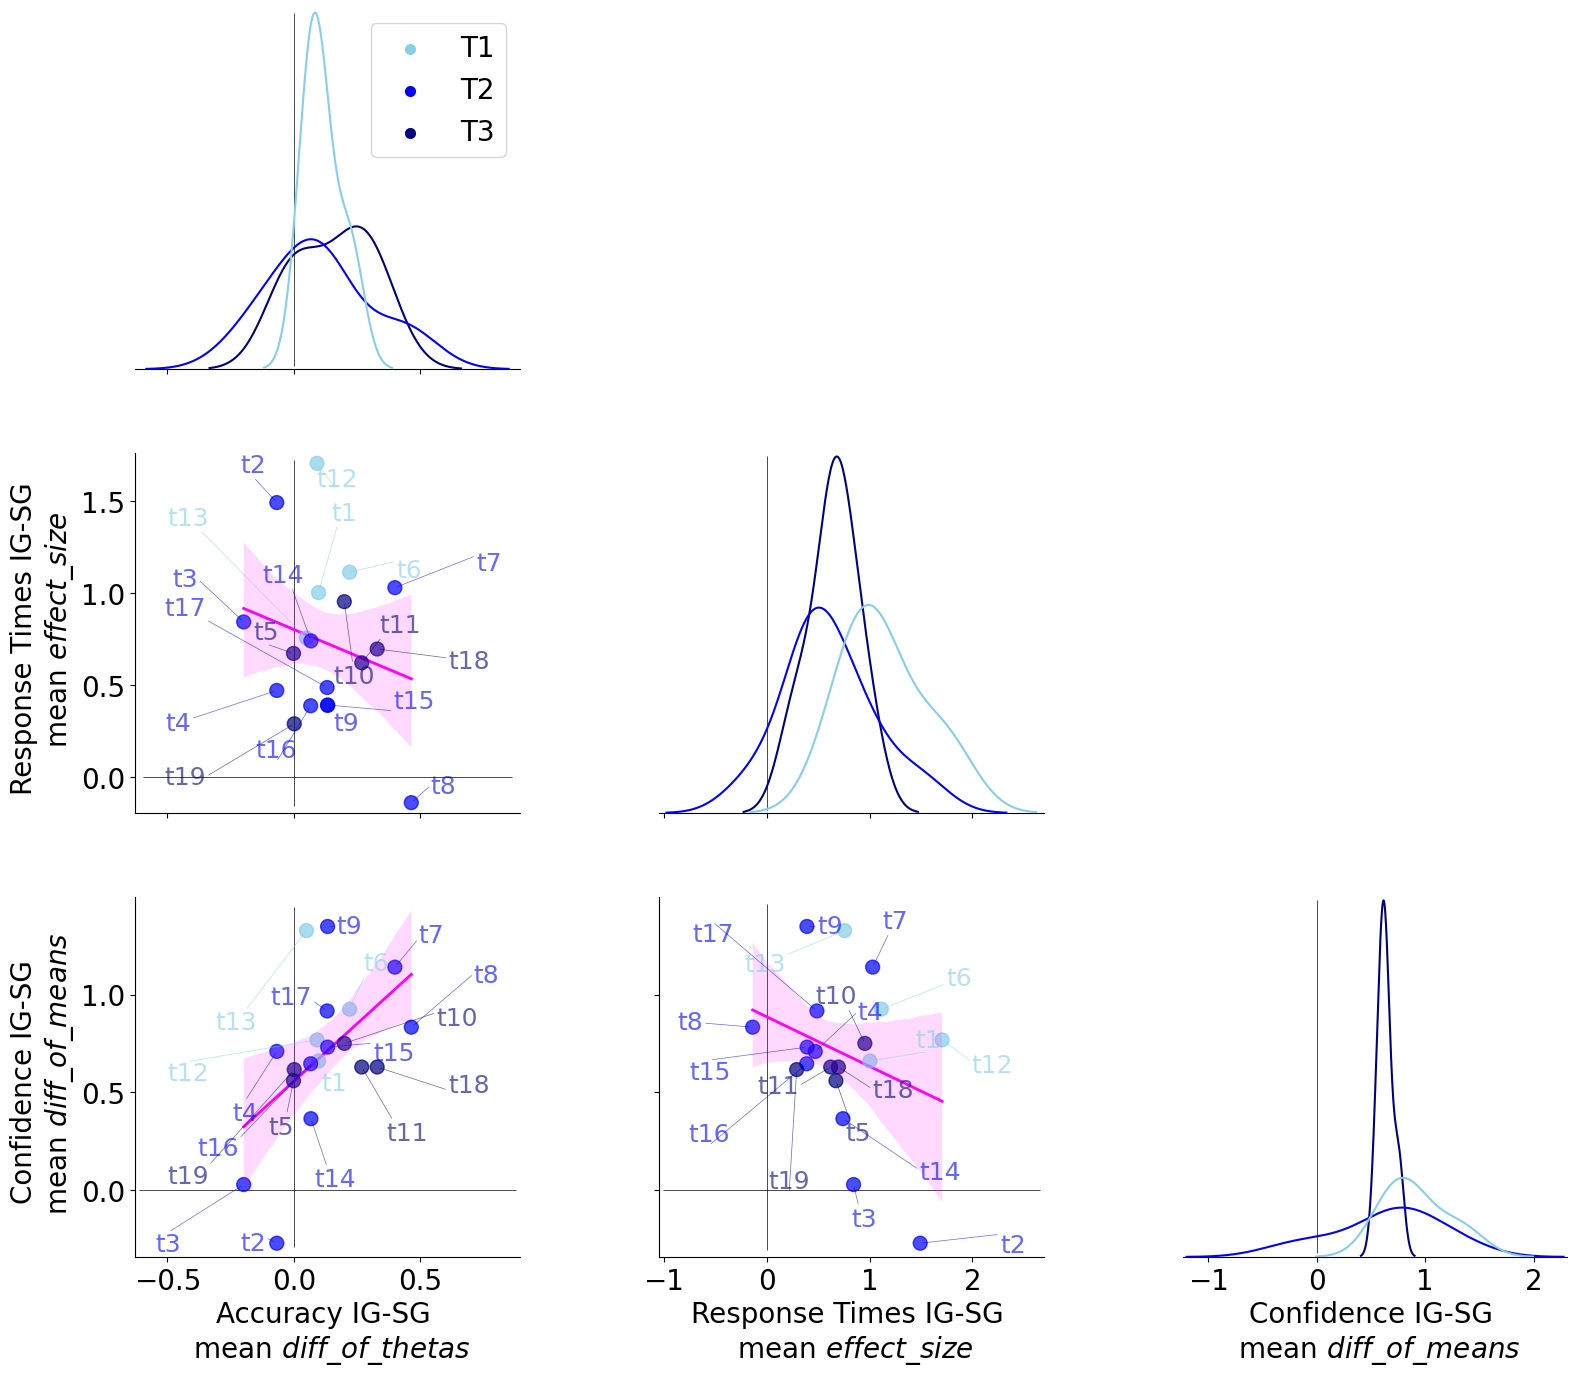

In [20]:
# data preparation
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc_rq1'] = (trace_acc_rq1,pp_acc_rq1,"difference of thetas")
traces_dict['acc_rq2'] = (trace_acc_rq2,pp_acc_rq2,"difference of thetas")
traces_dict['acc_rq3'] = (trace_acc_rq3,pp_acc_rq3,"difference of thetas")
traces_dict['rt_rq1'] = (trace_rt_rq1,pp_rt_rq1,"effect size")
traces_dict['rt_rq2'] = (trace_rt_rq2,pp_rt_rq2,"effect size")
traces_dict['rt_rq3'] = (trace_rt_rq3,pp_rt_rq3,"effect size")
traces_dict['conf_rq1'] = (trace_conf_rq1,pp_conf_rq1,"difference of means")
traces_dict['conf_rq2'] = (trace_conf_rq2,pp_conf_rq2,"difference of means")
traces_dict['conf_rq3'] = (trace_conf_rq3,pp_conf_rq3,"difference of means")
#
df, pp_data = get_data_response_pair_plot(t_ids, traces_dict)
pair_plot_of_means(df, pp_data)

## Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence

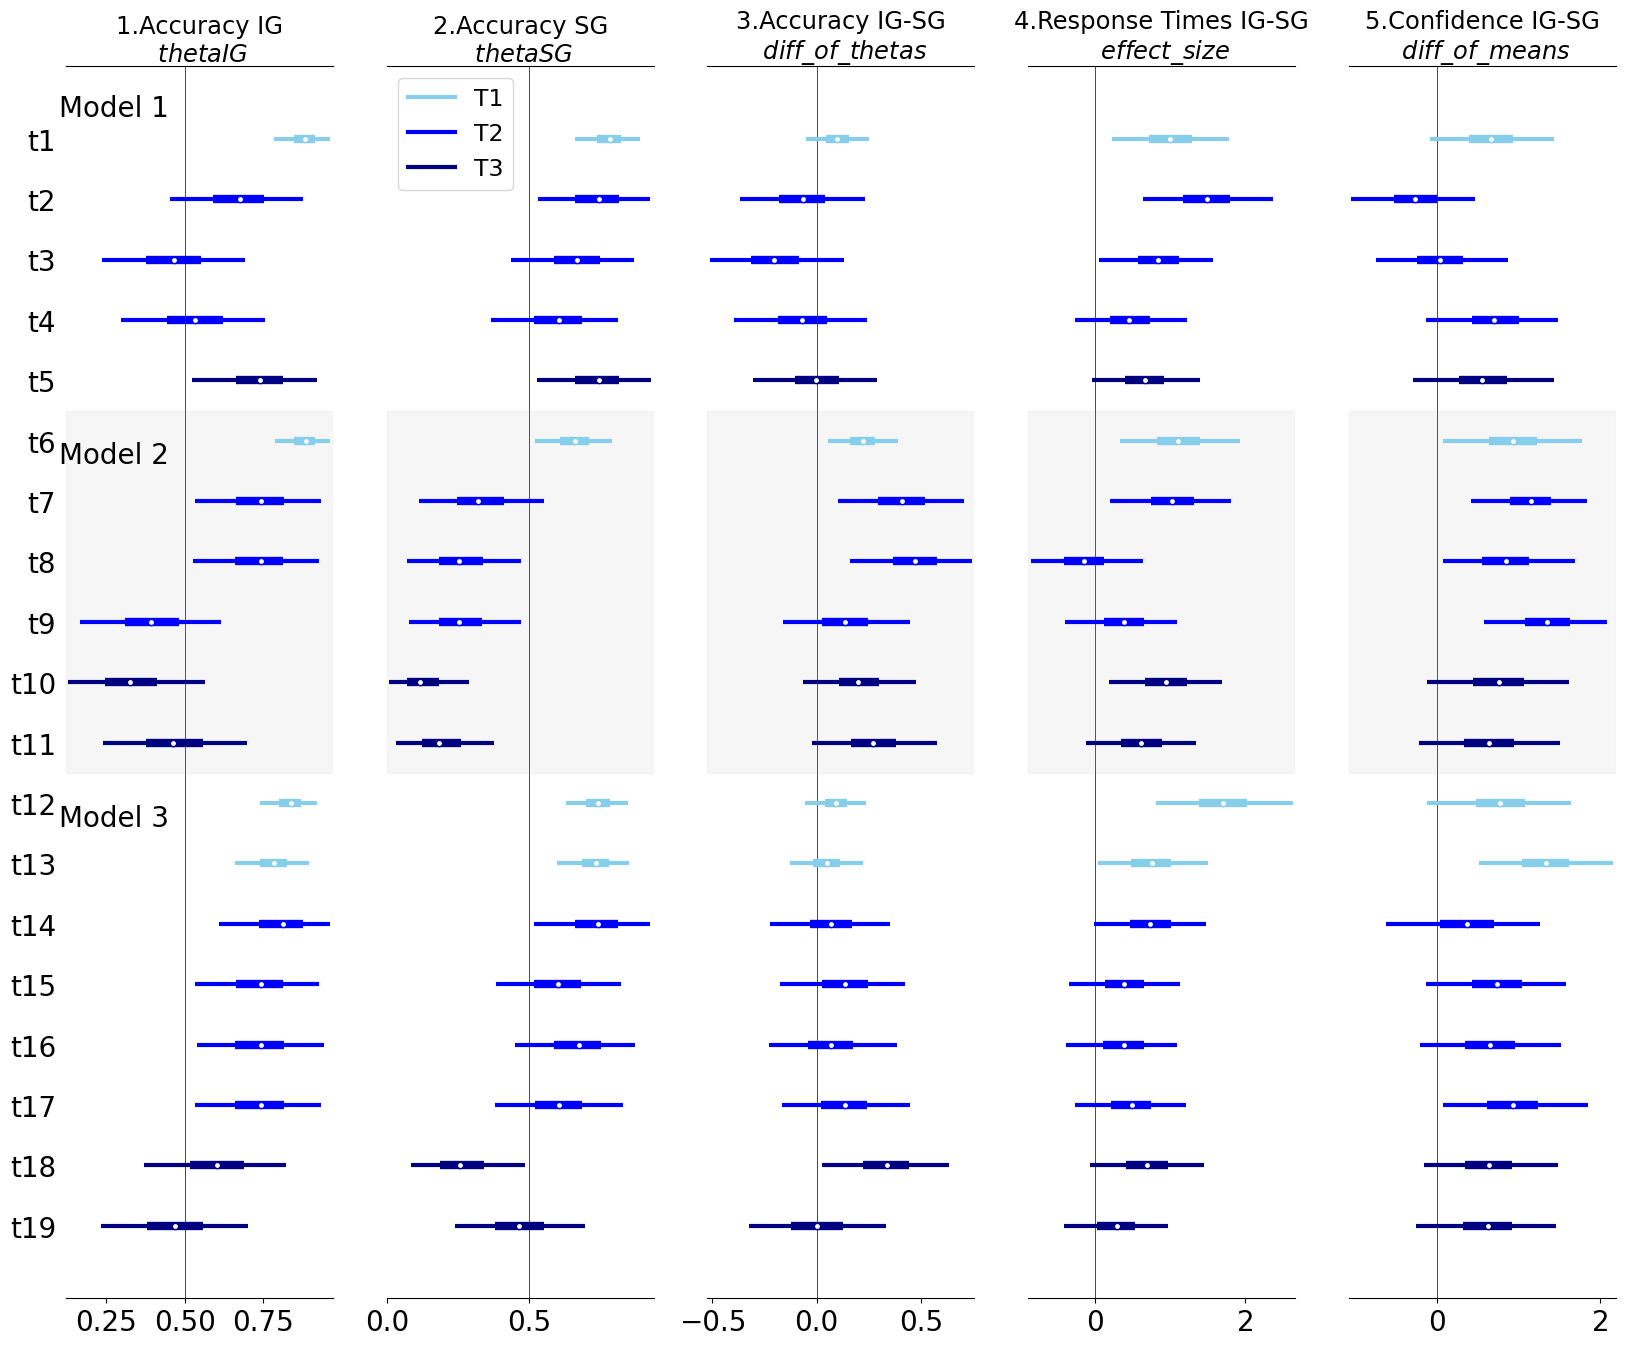

In [21]:
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc'] = [trace_acc_rq1, trace_acc_rq2, trace_acc_rq3]
traces_dict['rt'] = [trace_rt_rq1, trace_rt_rq2, trace_rt_rq3]
traces_dict['conf'] = [trace_conf_rq1, trace_conf_rq2, trace_conf_rq3]
forrest_plot_data = get_data_forest_plot(traces_dict)
#
axes = combined_forest_plot(forrest_plot_data)

## Ordered Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence

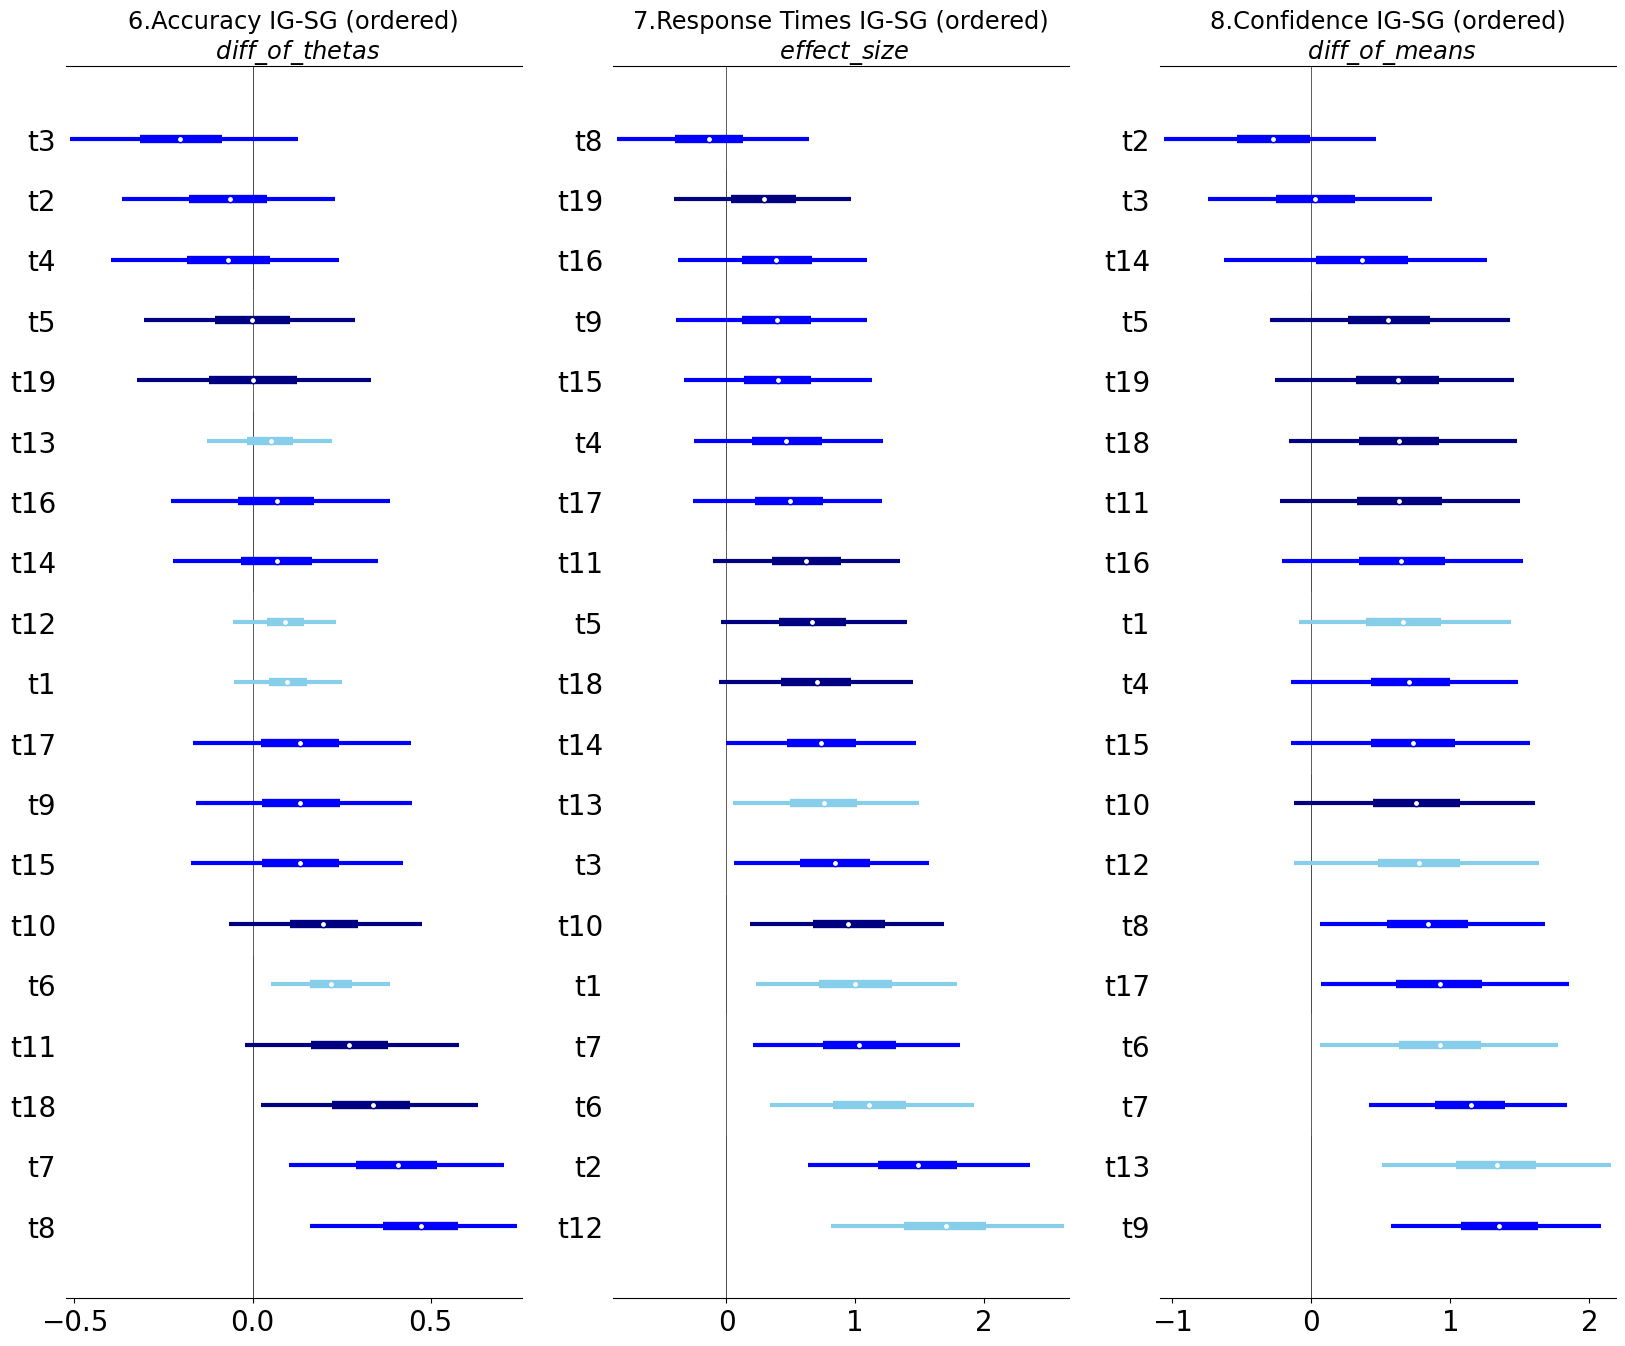

In [22]:
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc'] = [trace_acc_rq1, trace_acc_rq2, trace_acc_rq3]
traces_dict['rt'] = [trace_rt_rq1, trace_rt_rq2, trace_rt_rq3]
traces_dict['conf'] = [trace_conf_rq1, trace_conf_rq2, trace_conf_rq3]
forrest_plot_data = get_data_ordered_forest_plot(traces_dict)
#
axes = combined_oredered_forest_plot(forrest_plot_data)

## Quartiles of Observed Number and Length of Selection Boxes drawn

In [23]:
num_list = [el for array in num_of_boxes for el in array]  
mean_observed_num_of_boxes =  sum(num_list) / len(num_list)
print(mean_observed_num_of_boxes)
num_percentiles = np.percentile(num_list, [25, 50, 75])
print(num_percentiles)

#
len_list = [el for array in len_of_boxes for el in array]  
mean_observed_len_of_boxes =  sum(len_list) / len(len_list)
print(mean_observed_len_of_boxes)
len_percentiles = np.percentile(len_list, [25, 50, 75])
print(len_percentiles)

10.20242914979757
[ 4.5  9.  13. ]
0.18873438168655182
[0.10740741 0.16319614 0.2421004 ]


## Combined Forest Plot of Inference Results for Accuracy-Response Times-Confidence and Inference Results and Observations of Number and Length of Selection Boxes

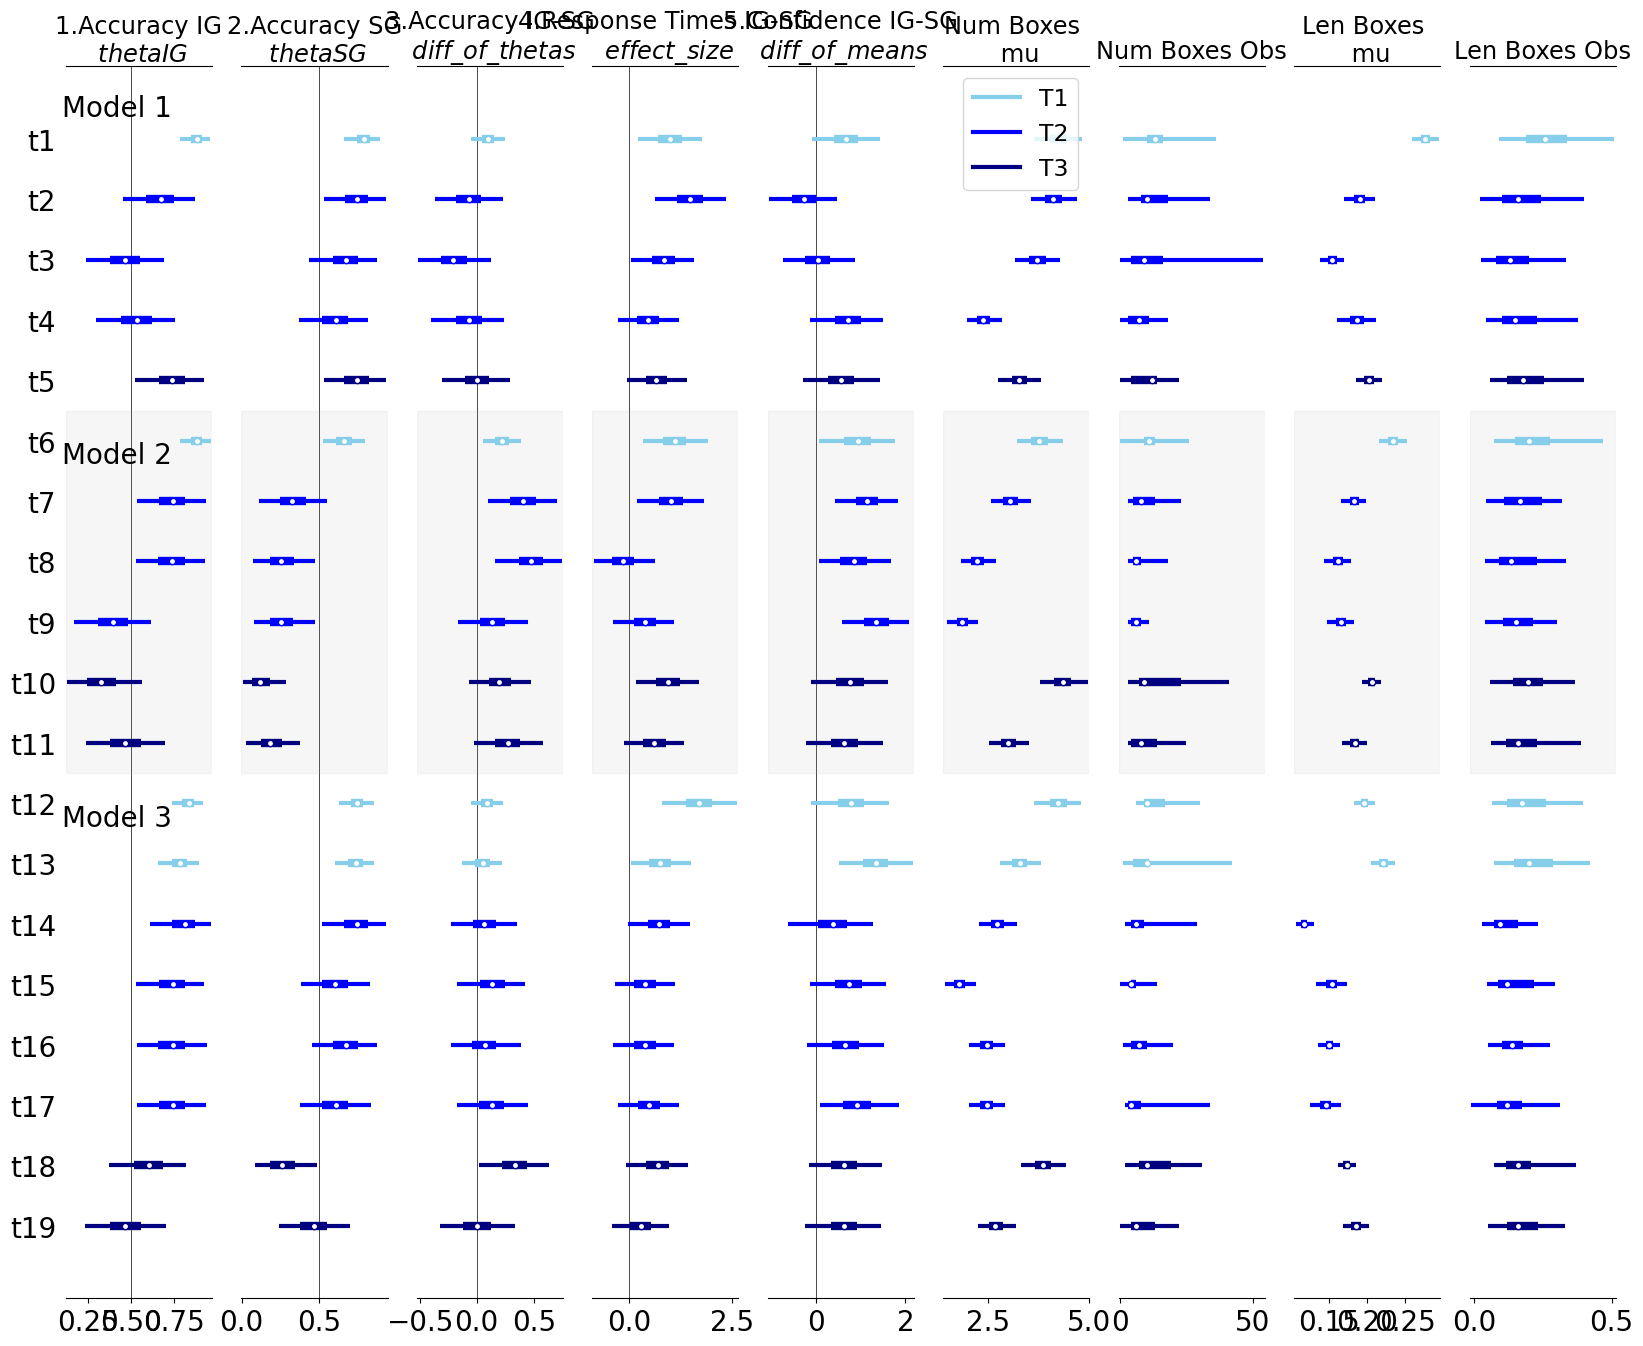

array([<AxesSubplot:title={'center':'1.Accuracy IG\n $\\it{thetaIG}$'}>,
       <AxesSubplot:title={'center':'2.Accuracy SG\n $\\it{thetaSG}$'}>,
       <AxesSubplot:title={'center':'3.Accuracy IG-SG\n $\\it{diff\\_of\\_thetas}$'}>,
       <AxesSubplot:title={'center':'4.Response Times IG-SG\n $\\it{effect\\_size}$'}>,
       <AxesSubplot:title={'center':'5.Confidence IG-SG\n $\\it{diff\\_of\\_means}$'}>,
       <AxesSubplot:title={'center':'Num Boxes \n mu'}>,
       <AxesSubplot:title={'center':'Num Boxes Obs'}>,
       <AxesSubplot:title={'center':'Len Boxes \n mu'}>,
       <AxesSubplot:title={'center':'Len Boxes Obs'}>], dtype=object)

In [24]:
traces_dict['num_boxes_obs'] = num_of_boxes
traces_dict['len_boxes_obs'] = len_of_boxes
traces_dict['num_boxes'] = [trace_num_boxes]
traces_dict['len_boxes'] = [trace_len_boxes]
#
forrest_plot_data_int = get_data_forest_plot(traces_dict)
combined_forest_plot(forrest_plot_data_int)

## Scatter Plot of Inferred Mean Values of Number and Length of Selection Boxes

In [25]:
# means of traces of hierarchical models
traces_dict = {}#{<trace_id>:(<trace>,<posterior_predictive_samples>,<variable>)}
traces_dict['acc_rq1'] = (trace_acc_rq1,pp_acc_rq1,"difference of thetas")
traces_dict['acc_rq2'] = (trace_acc_rq2,pp_acc_rq2,"difference of thetas")
traces_dict['acc_rq3'] = (trace_acc_rq3,pp_acc_rq3,"difference of thetas")
traces_dict['rt_rq1'] = (trace_rt_rq1,pp_rt_rq1,"effect size")
traces_dict['rt_rq2'] = (trace_rt_rq2,pp_rt_rq2,"effect size")
traces_dict['rt_rq3'] = (trace_rt_rq3,pp_rt_rq3,"effect size")
traces_dict['conf_rq1'] = (trace_conf_rq1,pp_conf_rq1,"difference of means")
traces_dict['conf_rq2'] = (trace_conf_rq2,pp_conf_rq2,"difference of means")
traces_dict['conf_rq3'] = (trace_conf_rq3,pp_conf_rq3,"difference of means")
traces_dict['num_boxes'] = (trace_num_boxes,pp_num_boxes,"mu")
traces_dict['len_boxes'] = (trace_len_boxes,pp_len_boxes,"mu")
# dict of means of traces
means = get_means_from_traces(traces_dict)

posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracyIG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable accuracySG's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not

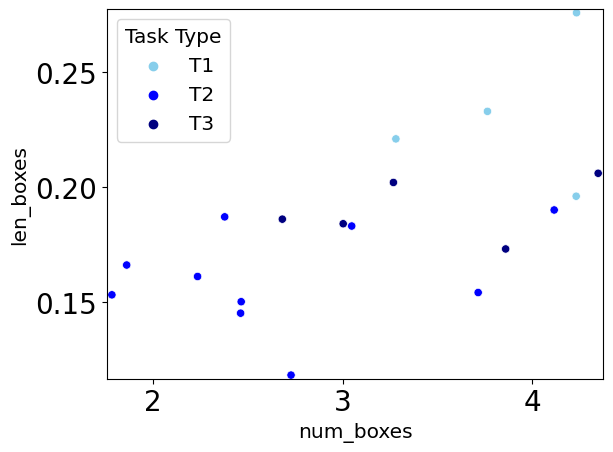

In [26]:
df_num_len_box = get_data_interaction_scatter_plot(means)
scatter_plot_of_num_len_boxes(df_num_len_box)

## Pair Plot of Means of Posteriors of Differences for Accuracy-Response Times-Confidence and Means of Posteriors of Mean Number and Lenght of Selection Boxes

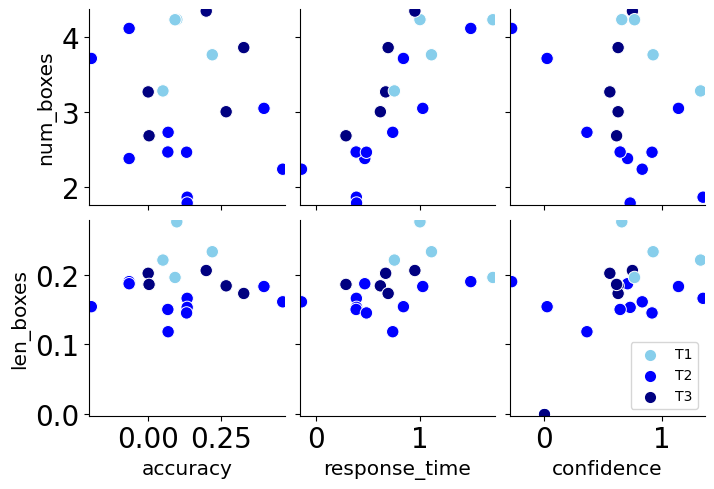

In [27]:
df_means_num, pp_data_num = get_data_response_interaction_pair_plot(means)
pair_plot_response_interaction(df_means_num, pp_data_num)